⚠️ Este notebook asume que el dataset ya fue descargado y ubicado en la carpeta `data/Anxiety/` siguiendo las instrucciones del README principal.

## Configuración

Si está ejecutando este notebook en Google Colab, ejecute la siguiente celda para instalar las bibliotecas que necesitamos:

In [1]:
!pip install datasets emoji
!pip install evaluate
!pip install transformers==4.28.0

In [2]:
# Clonar repositorio desde GitHub (solo si no existe la carpeta local)
REPO_URL = "https://github.com/manununhez/mentalrisk-nlp-ucom.git"
REPO_NAME = "mentalrisk-nlp-ucom"

import os

if not os.path.exists(REPO_NAME):
    # Clonado rápido (solo última versión, sin historial completo)
    !git clone --depth 1 {REPO_URL}

# Cambiar al directorio del repositorio
%cd {REPO_NAME}


/content/mentalrisk-nlp-ucom


# Parte 1: Preprocesamiento

## Cargar y explorar los datos

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Importar librerías

import os, json, re, html, unicodedata, pathlib, warnings, itertools, pprint, joblib
import pandas as pd
import numpy as np
#from emoji import demojize                 # ←  convierte 🙂 → :slightly_smiling_face:
warnings.filterwarnings("ignore")

import sys
sys.path.append("utils")  # Asegura que Python pueda encontrar el módulo

from text_cleaning import clean_text
from data_loader import build_df_from_folder

In [8]:
# Unir todos los sub-corpora

SUBSETS = {
    "Anxiety": {
        "json_dir": "/content/drive/MyDrive/data/Anxiety/data",
        "csv_path": "/content/drive/MyDrive/data/Anxiety/gold/gold_label.csv",
    },
    # descomenta / añade si tienes Depresión y TCA
    # "Depression": { … },
    # "TCA":        { … },
}

df_all_processed = pd.concat([build_df_from_folder(v["json_dir"], v["csv_path"]) for v in SUBSETS.values()], ignore_index=True)

Distribución final de etiquetas:
label
1    443
0     57
Name: count, dtype: int64


In [9]:
# Verificar el contenido del df_all_processed

print(df_all_processed.head())
print(df_all_processed.info())
print(df_all_processed.describe())

         user  label                                      message_clean
0    subject1      1  buenos días a tod mention no sé si esta será l...
1   subject10      0  ola soi nuebo como estn a ustds los entimdm ke...
2  subject100      1  de donde son yo de perú supongo q tb sigue en ...
3  subject101      1  es lo que necesitas aaah pues perdón por no ha...
4  subject102      1  ya perdí una xd siete seguidas no está mal el ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user           500 non-null    object
 1   label          500 non-null    int64 
 2   message_clean  500 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.8+ KB
None
           label
count  500.00000
mean     0.88600
std      0.31813
min      0.00000
25%      1.00000
50%      1.00000
75%      1.00000
max      1.00000


In [17]:
# Guardamos a disco

csv_backup_name = 'MentalRiskES_finetuning_userlevel_clean_processed.csv'
df_all_processed.to_csv(csv_backup_name, index=False)
print(f"CSV guardado → {csv_backup_name}")

CSV guardado → MentalRiskES_finetuning_userlevel_clean_processed.csv


In [40]:
# Inicializar lista para guardar resultados de cada configuración
resultados_modelo = []

## Distribución de clases

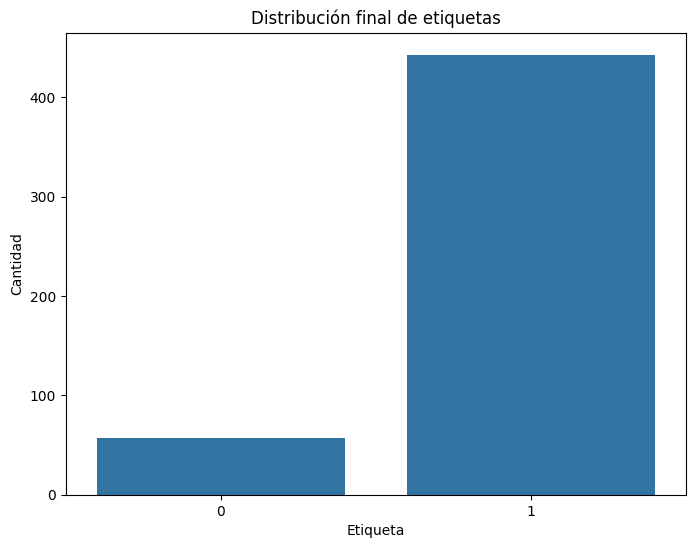

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura si es necesario
sns.countplot(x="label", data=df_all_processed)
plt.title("Distribución final de etiquetas")
plt.xlabel("Etiqueta")
plt.ylabel("Cantidad")
plt.show()

La clase `0` (Control) representa solo ~10% de los ejemplos, lo que confirma el fuerte desbalance. Esto justifica aplicar técnicas de balanceo como `class_weight` y threshold tuning más adelante.


## Separar en train/test

In [18]:
df_user_level = pd.read_csv(csv_backup_name)

In [20]:
from sklearn.model_selection import train_test_split

# Primero divide la lista de usuarios únicos respetando el balance (stratify).
# Luego filtra las filas completas para esos usuarios.
# Clasificamos por usuario (no por mensaje aislado), y asi aseguramos que las evaluaciones no contaminen los datos con ejemplos del mismo usuario en ambos conjuntos.

train_users, test_users = train_test_split(
    df_user_level['user'], test_size=0.3, random_state=42,
    stratify=df_user_level['label']
)

train_df = df_user_level[df_user_level['user'].isin(train_users)].reset_index(drop=True)
test_df = df_user_level[df_user_level['user'].isin(test_users)].reset_index(drop=True)

print(f"Train size: {train_df.shape[0]}, Test size: {test_df.shape[0]}")

Train size: 350, Test size: 150


## Crear DatasetDict para Huggingface

In [21]:
from datasets import Dataset, DatasetDict

dataset_train = Dataset.from_pandas(train_df[["message_clean", "label"]].rename(columns={"message_clean": "text"}))
dataset_test = Dataset.from_pandas(test_df[["message_clean", "label"]].rename(columns={"message_clean": "text"}))

dataset_dict = DatasetDict({
    "train": dataset_train,
    "test": dataset_test
})

print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 350
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 150
    })
})


In [22]:
import random
import pandas as pd
from datasets import ClassLabel
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    "Taken from https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb"

    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [23]:
show_random_elements(dataset_dict['test'], num_examples=3)

# Parte 2: Ajuste fino del modelo preentrenado


Entrenamiento con roberta-base-bne

## Cargar el tokenizador y modelo

In [24]:
from transformers import AutoTokenizer

model_checkpoint = "PlanTL-GOB-ES/roberta-base-bne"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

## Tokenización

In [25]:
tokenizer.vocab_size

50262

In [26]:
def tokenize(example):
    return tokenizer(
        example["text"],
        padding="max_length",    # Que todos los textos tengan la misma longitud
        truncation=True,         # Cortar si excede el máximo
        max_length=512           # 512 porque RoBERTa-BNE permite el máximo estándar de entrada y nuestros textos por usuario pueden ser largos.
    )

## Aplicar tokenización al DatasetDict preparado

In [27]:
tokenized_datasets = dataset_dict.map(tokenize,
                                      batched=True,
                                      remove_columns=["text"]  # Eliminamos 'text' original porque ya está tokenizado
)


tokenized_datasets

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 350
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 150
    })
})

## Cargar el modelo de BETO preentrenado para clasificación binaria

In [28]:
from transformers import AutoModelForSequenceClassification

num_labels = 2 # 0 (control), 1 (ansiedad)

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.out_proj.weight', 'classi

## Definir las métricas de evaluación

In [29]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## Definir TrainingArguments y preparar el Trainer

In [30]:
from transformers import TrainingArguments

model_name = model_checkpoint.split("/")[-1]

batch_size = 16
num_train_epochs=4

test_dataset = tokenized_datasets["test"]
train_dataset = tokenized_datasets["train"]

logging_steps = len(train_dataset) // (2 * batch_size * num_train_epochs)


training_args = TrainingArguments(
    output_dir="./resultados-beto-anxiety",
    evaluation_strategy="epoch",      # Evaluar al final de cada epoch
    save_strategy="epoch",             # Guardar el modelo al final de cada epoch
    num_train_epochs=num_train_epochs, # Entre 3 y 5, elegimos 4 como punto medio
    learning_rate=5e-5,                # Tasa de aprendizaje inicial
    per_device_train_batch_size=batch_size,    # Batch size de entrenamiento
    per_device_eval_batch_size=batch_size,     # Batch size para evaluación
    weight_decay=0.01,                 # Regularización para evitar overfitting
    load_best_model_at_end=True,       # Cargar el mejor modelo en validación
    metric_for_best_model="f1",        # Seleccionar el modelo según mejor F1 (lo configuramos ahora)
    greater_is_better=True,            # Porque mayor F1 es mejor
    logging_dir="./logs",              # Carpeta de logs
    logging_steps=logging_steps,       # Cada X steps se guarda log
    # save_total_limit=2,                 # Guardar solo los 2 mejores checkpoints
    report_to="none"  # Para evitar errores si no usás wandb
)

## Entrenamiento (fine-tuning)

####  Liberar memoria previa (entre reentrenamientos) Opcional

In [31]:
import gc
gc.collect()

import torch
torch.cuda.empty_cache()

In [32]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [33]:
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.385400,0.309381,0.886667,0.886667,1.000000,0.939929
2,0.379200,0.252546,0.900000,0.921429,0.969925,0.945055
3,0.287000,0.351442,0.893333,0.903448,0.984962,0.942446
4,0.119400,0.364247,0.900000,0.909722,0.984962,0.945848


TrainOutput(global_step=88, training_loss=0.2314439673315395, metrics={'train_runtime': 196.4188, 'train_samples_per_second': 7.128, 'train_steps_per_second': 0.448, 'total_flos': 368355477504000.0, 'train_loss': 0.2314439673315395, 'epoch': 4.0})

El modelo `roberta-base-bne` fue entrenado correctamente. En las siguientes secciones se analizará su rendimiento base y se aplicarán técnicas de mejora (pesos balanceados, ajuste de threshold).


## Parte 3: Evaluación del modelo

### Evaluación Base

In [34]:
# O sobre el conjunto de prueba
trainer.evaluate(test_dataset)

{'eval_loss': 0.3642467260360718,
 'eval_accuracy': 0.9,
 'eval_precision': 0.9097222222222222,
 'eval_recall': 0.9849624060150376,
 'eval_f1': 0.9458483754512635,
 'eval_runtime': 4.9351,
 'eval_samples_per_second': 30.395,
 'eval_steps_per_second': 2.026,
 'epoch': 4.0}

In [35]:
model.save_pretrained("./beto-mentalrisk-anxiety")
tokenizer.save_pretrained("./beto-mentalrisk-anxiety")

('./beto-mentalrisk-anxiety/tokenizer_config.json',
 './beto-mentalrisk-anxiety/special_tokens_map.json',
 './beto-mentalrisk-anxiety/vocab.json',
 './beto-mentalrisk-anxiety/merges.txt',
 './beto-mentalrisk-anxiety/added_tokens.json',
 './beto-mentalrisk-anxiety/tokenizer.json')

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Realizar predicciones sobre el conjunto de test
predictions = trainer.predict(test_dataset)

# Obtener las etiquetas predichas
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

Text(0.5, 1.0, 'Matriz de Confusión - RoBERTa sin ajuste')

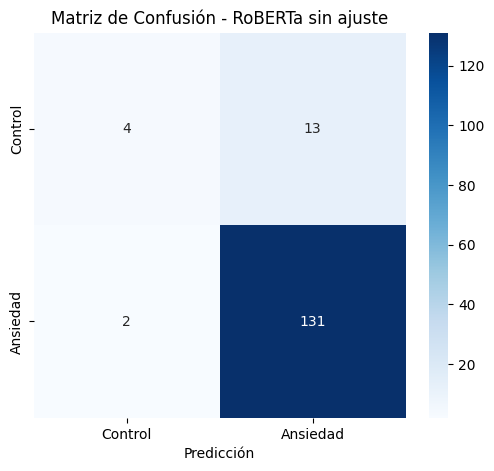

In [37]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
labels = ["Control", "Ansiedad"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicción')
plt.title("Matriz de Confusión - RoBERTa sin ajuste")

In [38]:
# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

     Control       0.67      0.24      0.35        17
    Ansiedad       0.91      0.98      0.95       133

    accuracy                           0.90       150
   macro avg       0.79      0.61      0.65       150
weighted avg       0.88      0.90      0.88       150



In [41]:
from sklearn.metrics import classification_report

# Generar reporte
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

# Guardar la configuración actual y sus métricas
resultados_modelo.append({
    "Modelo": "RoBERTa",
    "class_weight": False,
    "Threshold": 0.0,
    "F1-Control": report["0"]["f1-score"],
    "F1-Ansiedad": report["1"]["f1-score"],
    "Accuracy": report["accuracy"]
})

###  Evaluación con ajuste de threshold

 La idea es mejorar el balance entre sensibilidad (recall) y precisión, especialmente en la clase Control, aplicando un threshold ajustado al modelo entrenado con class_weight.

 El ajuste de threshold permite mejorar significativamente el F1-score de la clase `Control`, sin afectar drásticamente el desempeño en la clase `Ansiedad`.

Este paso es esencial cuando el modelo tiene una tendencia a sobrepredecir la clase positiva debido al desbalance original del dataset.

In [42]:
from scipy.special import softmax

logits = predictions.predictions

# Probabilidades de clase 1 (Ansiedad)
probs = softmax(logits, axis=1)[:, 1]

In [43]:
import numpy as np
from sklearn.metrics import classification_report

thresholds = np.arange(0.3, 0.85, 0.05)
print("Threshold\tF1-Control\tF1-Ansiedad\tAccuracy")

for t in thresholds:
    preds = (probs >= t).astype(int)
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)
    f1_0 = report["0"]["f1-score"]
    f1_1 = report["1"]["f1-score"]
    acc = report["accuracy"]
    print(f"{t:.2f}\t\t{f1_0:.3f}\t\t{f1_1:.3f}\t\t{acc:.3f}")

Threshold	F1-Control	F1-Ansiedad	Accuracy
0.30		0.273		0.942		0.893
0.35		0.348		0.946		0.900
0.40		0.348		0.946		0.900
0.45		0.348		0.946		0.900
0.50		0.348		0.946		0.900
0.55		0.348		0.946		0.900
0.60		0.348		0.946		0.900
0.65		0.348		0.946		0.900
0.70		0.348		0.946		0.900
0.75		0.417		0.949		0.907
0.80		0.417		0.949		0.907


In [44]:
# Elegimos el threshold óptimo (ej. 0.80)
threshold = 0.80
y_pred_final = (probs >= threshold).astype(int)

# Reporte final
print(classification_report(y_true, y_pred_final, target_names=labels))

              precision    recall  f1-score   support

     Control       0.71      0.29      0.42        17
    Ansiedad       0.92      0.98      0.95       133

    accuracy                           0.91       150
   macro avg       0.82      0.64      0.68       150
weighted avg       0.89      0.91      0.89       150



In [45]:
# Generar reporte
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

# Guardar la configuración actual y sus métricas
resultados_modelo.append({
    "Modelo": "RoBERTa",
    "class_weight": False,
    "Threshold": threshold,
    "F1-Control": report["0"]["f1-score"],
    "F1-Ansiedad": report["1"]["f1-score"],
    "Accuracy": report["accuracy"]
})

Se observa que el modelo tiene un muy buen desempeño para la clase mayoritaria (Ansiedad), pero bajo F1-score para la clase `Control` (≈ 0.20).

👉 Esto motiva aplicar estrategias para mejorar el rendimiento en la clase minoritaria:
- Ponderación de clases (`class_weight`)
- Ajuste de threshold manual


¿Por qué aplicar balanceo y ajuste de threshold?

El modelo `roberta-base-bne` fue entrenado sobre un dataset con un **fuerte desbalance**: más del 85% de los usuarios están etiquetados como `Ansiedad` (clase 1), mientras que la clase `Control` (0) está poco representada.

Este desbalance puede provocar que:
- El modelo **priorice la clase 1** y no aprenda correctamente los patrones de la clase minoritaria.
- Se obtenga una **accuracy artificialmente alta**, mientras que el **F1-score de la clase 0 sea muy bajo** (incluso cercano a 0.00).

Por lo tanto, primero evaluaremos el modelo **sin ninguna estrategia de compensación** como línea base. Luego, en las siguientes secciones, se aplicarán:
- `class_weight`: para darle más importancia a la clase 0 durante el entrenamiento.
- Ajuste de `threshold`: para controlar cuán fácilmente el modelo predice clase 1.

Este enfoque permite medir el impacto real de cada técnica sobre el rendimiento del modelo, en especial sobre la clase minoritaria.

### Entrenamiento con class_weight

La idea es incorporar un peso mayor a la clase minoritaria (Control) durante el entrenamiento, para forzar al modelo a prestarle más atención a sus patrones.

Con esta estrategia, el modelo penaliza más los errores en la clase 0, lo que debería mejorar su rendimiento (recall y F1-score) para detectar usuarios sin ansiedad.
En la siguiente sección, se aplicará ajuste de threshold para mejorar aún más la precisión.


In [46]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Obtener etiquetas de entrenamiento
y_train = train_df["label"].values

# Calcular pesos balanceados
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print("Pesos de clase:", class_weights)

Pesos de clase: tensor([4.3750, 0.5645])


#### Trainer personalizada con CrossEntropyLoss ponderada


In [47]:
from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

#### Reentrenar modelo

In [48]:
trainer_w = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [49]:
trainer_w.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.044200,1.406371,0.906667,0.910345,0.992481,0.949640
2,0.541200,1.151578,0.886667,0.908451,0.969925,0.938182
3,0.904800,1.265008,0.893333,0.914894,0.969925,0.941606
4,0.014500,0.963494,0.900000,0.933824,0.954887,0.944238


TrainOutput(global_step=88, training_loss=0.28058952527036046, metrics={'train_runtime': 201.165, 'train_samples_per_second': 6.959, 'train_steps_per_second': 0.437, 'total_flos': 368355477504000.0, 'train_loss': 0.28058952527036046, 'epoch': 4.0})

In [50]:
trainer_w.evaluate(test_dataset)

{'eval_loss': 1.4063705205917358,
 'eval_accuracy': 0.9066666666666666,
 'eval_precision': 0.9103448275862069,
 'eval_recall': 0.9924812030075187,
 'eval_f1': 0.9496402877697842,
 'eval_runtime': 5.0403,
 'eval_samples_per_second': 29.76,
 'eval_steps_per_second': 1.984,
 'epoch': 4.0}

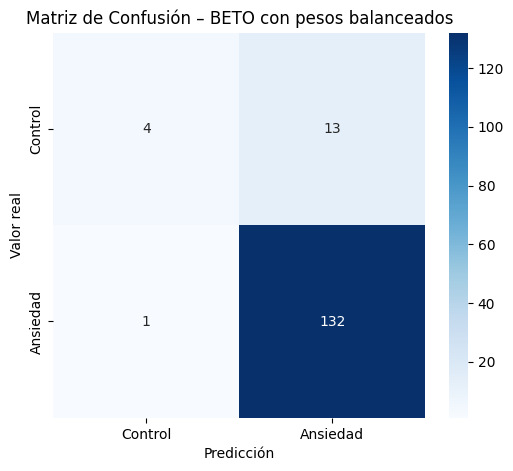

In [51]:
# Predicciones
predictions = trainer_w.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Matriz de confusión
labels = ["Control", "Ansiedad"]
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión – BETO con pesos balanceados")
plt.show()

In [52]:
# Reporte
print("Reporte clasificación:")
print(classification_report(y_true, y_pred, target_names=labels))

Reporte clasificación:
              precision    recall  f1-score   support

     Control       0.80      0.24      0.36        17
    Ansiedad       0.91      0.99      0.95       133

    accuracy                           0.91       150
   macro avg       0.86      0.61      0.66       150
weighted avg       0.90      0.91      0.88       150



In [53]:
# Generar reporte
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

# Guardar la configuración actual y sus métricas
resultados_modelo.append({
    "Modelo": "RoBERTa",
    "class_weight": True,
    "Threshold": 0.0,
    "F1-Control": report["0"]["f1-score"],
    "F1-Ansiedad": report["1"]["f1-score"],
    "Accuracy": report["accuracy"]
})

In [54]:
model.save_pretrained("./beto-mentalrisk-anxiety-weighted")
tokenizer.save_pretrained("./beto-mentalrisk-anxiety-weighted")

('./beto-mentalrisk-anxiety-weighted/tokenizer_config.json',
 './beto-mentalrisk-anxiety-weighted/special_tokens_map.json',
 './beto-mentalrisk-anxiety-weighted/vocab.json',
 './beto-mentalrisk-anxiety-weighted/merges.txt',
 './beto-mentalrisk-anxiety-weighted/added_tokens.json',
 './beto-mentalrisk-anxiety-weighted/tokenizer.json')

###  Evaluación con ajuste de threshold (modelo con class_weight)

 La idea es mejorar el balance entre sensibilidad (recall) y precisión, especialmente en la clase Control, aplicando un threshold ajustado al modelo entrenado con class_weight.

 El ajuste de threshold permite mejorar significativamente el F1-score de la clase `Control`, sin afectar drásticamente el desempeño en la clase `Ansiedad`.

Este paso es esencial cuando el modelo tiene una tendencia a sobrepredecir la clase positiva debido al desbalance original del dataset.

In [55]:
from scipy.special import softmax

logits = predictions.predictions

# Probabilidades de clase 1 (Ansiedad)
probs = softmax(logits, axis=1)[:, 1]

In [56]:
import numpy as np
from sklearn.metrics import classification_report

thresholds = np.arange(0.3, 0.85, 0.05)
print("Threshold\tF1-Control\tF1-Ansiedad\tAccuracy")

for t in thresholds:
    preds = (probs >= t).astype(int)
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)
    f1_0 = report["0"]["f1-score"]
    f1_1 = report["1"]["f1-score"]
    acc = report["accuracy"]
    print(f"{t:.2f}\t\t{f1_0:.3f}\t\t{f1_1:.3f}\t\t{acc:.3f}")

Threshold	F1-Control	F1-Ansiedad	Accuracy
0.30		0.286		0.946		0.900
0.35		0.286		0.946		0.900
0.40		0.286		0.946		0.900
0.45		0.286		0.946		0.900
0.50		0.364		0.950		0.907
0.55		0.364		0.950		0.907
0.60		0.364		0.950		0.907
0.65		0.348		0.946		0.900
0.70		0.333		0.942		0.893
0.75		0.333		0.942		0.893
0.80		0.333		0.942		0.893


In [57]:
# Elegimos el threshold óptimo
threshold = 0.50
y_pred_final = (probs >= threshold).astype(int)

# Reporte final
print(classification_report(y_true, y_pred_final, target_names=labels))

              precision    recall  f1-score   support

     Control       0.80      0.24      0.36        17
    Ansiedad       0.91      0.99      0.95       133

    accuracy                           0.91       150
   macro avg       0.86      0.61      0.66       150
weighted avg       0.90      0.91      0.88       150



In [58]:
# Generar reporte
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

# Guardar la configuración actual y sus métricas
resultados_modelo.append({
    "Modelo": "RoBERTa",
    "class_weight": True,
    "Threshold": threshold,
    "F1-Control": report["0"]["f1-score"],
    "F1-Ansiedad": report["1"]["f1-score"],
    "Accuracy": report["accuracy"]
})

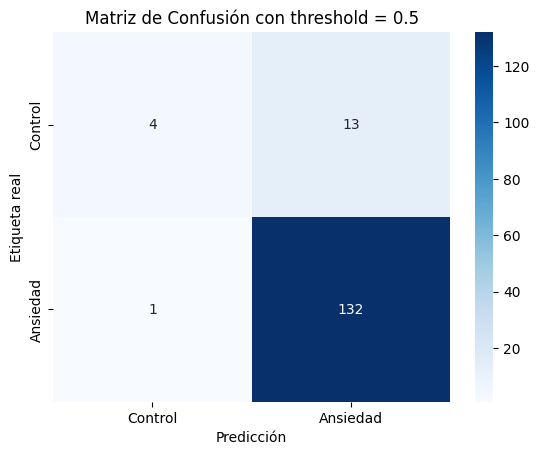

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_final)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Control", "Ansiedad"], yticklabels=["Control", "Ansiedad"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title(f"Matriz de Confusión con threshold = {threshold}")
plt.show()

### Evaluaciones manuales (Validación cualitativa del modelo)

In [60]:
import torch
from transformers import TextClassificationPipeline

# Crear pipeline de clasificación desde el modelo entrenado
pipeline_personalizado = TextClassificationPipeline(
    model=trainer_w.model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)

In [61]:
import pandas as pd

textos_prueba = [
    "No puedo dormir, mi corazón late muy rápido por las noches.",
    "Me sudan las manos cuando estoy solo.",
    "A veces me falta el aire sin razón aparente.",
    "Siento que algo malo va a pasar aunque no hay motivo.",
    "Estoy harto, no sé cómo parar estos pensamientos.",
    "Hoy me desperté feliz, con muchas ganas de salir.",
    "Todo está en calma, me siento estable emocionalmente.",
    "Amo mi trabajo y estoy disfrutando la vida.",
    "No tengo ansiedad, solo algo de cansancio normal.",
    "La terapia me ha ayudado mucho, ya no tengo miedo.",
]

def evaluar_textos(textos):
    resultados = []
    for texto in textos:
        resultado = pipeline_personalizado(texto)[0]
        prob_sufre = resultado[1]['score']
        etiqueta = "Sufre ansiedad" if prob_sufre >= 0.5 else "Control (no sufre)"
        resultados.append({
            "Texto": texto,
            "Predicción": etiqueta,
            "Prob. Ansiedad": round(prob_sufre, 4)
        })
    return pd.DataFrame(resultados).sort_values(by="Prob. Ansiedad", ascending=False)

df_resultados = evaluar_textos(textos_prueba)

In [62]:
df_resultados

,Texto,Predicción,Prob. Ansiedad
8,"No tengo ansiedad, solo algo de cansancio normal.",Sufre ansiedad,0.9861
4,"Estoy harto, no sé cómo parar estos pensamientos.",Sufre ansiedad,0.9667
0,"No puedo dormir, mi corazón late muy rápido po...",Sufre ansiedad,0.9560
9,"La terapia me ha ayudado mucho, ya no tengo mi...",Control (no sufre),0.3973
6,"Todo está en calma, me siento estable emociona...",Control (no sufre),0.2502
1,Me sudan las manos cuando estoy solo.,Control (no sufre),0.1289
5,"Hoy me desperté feliz, con muchas ganas de salir.",Control (no sufre),0.1230
2,A veces me falta el aire sin razón aparente.,Control (no sufre),0.0679
7,Amo mi trabajo y estoy disfrutando la vida.,Control (no sufre),0.0503
3,Siento que algo malo va a pasar aunque no hay ...,Control (no sufre),0.0402


📌 Esta evaluación cualitativa muestra que el modelo:
- Asigna alta probabilidad de ansiedad a frases con síntomas explícitos.
- Clasifica correctamente textos neutros o positivos como `Control`.
- Permite interpretar sus predicciones gracias a las probabilidades de salida.


### Comparación de resultados

In [63]:
import pandas as pd

df_resultadosTabla = pd.DataFrame(resultados_modelo)
df_resultadosTabla = df_resultadosTabla.sort_values(by="F1-Control", ascending=False).reset_index(drop=True)
print(df_resultadosTabla)

    Modelo  class_weight  Threshold  F1-Control  F1-Ansiedad  Accuracy
0  RoBERTa          True        0.5    0.363636     0.949640  0.906667
1  RoBERTa          True        0.0    0.363636     0.949640  0.906667
2  RoBERTa         False        0.8    0.347826     0.945848  0.900000
3  RoBERTa         False        0.0    0.347826     0.945848  0.900000
